In [1]:
import os
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
from functools import reduce
from scipy.stats import bartlett
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
all_path_corr = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/with_color_correction/All/'
first_path_corr = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/with_color_correction/1/'
second_path_corr = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/with_color_correction/2/'

all_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/without_color_correction/All/'
first_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/without_color_correction/1/'
second_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/without_color_correction/2/'

img_path_with_corr = '/home/jupyter-fly_cv/Igor/Plants/data/color_correction_01.02.22/'
img_path = '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды'

global_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/'

In [3]:
last = ['/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_07_08/',
        '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_10_08/',
        '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/',
        '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/',
        '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/',
       ]
first = ['/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/1/2020_06_26/',
         '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/2/2020_09_24/',
         '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_05/',
         '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_10_20/',
         '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_03/',
       ]

In [4]:
annot = pd.read_csv('/home/jupyter-fly_cv/Igor/Plants/annotation.csv', sep = ';')
f_annot = annot.copy()
f_annot = f_annot.query(" (Устьица == 'гаплоид' | Устьица == 'диплоид') | (хромосомы == 'гаплоид'| хромосомы == 'диплоид')")
f_annot = f_annot.reset_index(drop=True)
f_annot

,Порядковый номер,Номер растения,Устьица,хромосомы
0,1,Н16/1,гаплоид,гаплоид
1,2,Н16/2,диплоид,диплоид
2,3,991/1,гаплоид,гаплоид
3,4,991/2,диплоид,гаплоид
4,5,991/3,диплоид,диплоид
...,...,...,...,...
138,151,454/83,диплоид,диплоид
139,152,454/84,диплоид,диплоид
140,153,454/85,диплоид,?
141,154,454/86,диплоид,диплоид


In [5]:
for i in f_annot.index:
    if f_annot.loc[i,'хромосомы'] == 'гаплоид?':
        #print(i)
        f_annot.loc[i,'хромосомы'] = 'гаплоид'
    if f_annot.loc[i,'хромосомы'] == 'диплоид?':
        #print(i)
        f_annot.loc[i,'хромосомы'] = 'диплоид'
    if f_annot.loc[i,'хромосомы'] != 'гаплоид' and f_annot.loc[i,'хромосомы'] != 'диплоид':
        f_annot.loc[i,'хромосомы'] = f_annot.loc[i,'Устьица']
f_annot = f_annot.drop(columns = ['Устьица'])
f_annot

,Порядковый номер,Номер растения,хромосомы
0,1,Н16/1,гаплоид
1,2,Н16/2,диплоид
2,3,991/1,гаплоид
3,4,991/2,гаплоид
4,5,991/3,диплоид
...,...,...,...
138,151,454/83,диплоид
139,152,454/84,диплоид
140,153,454/85,диплоид
141,154,454/86,диплоид


In [6]:
def refuse_null(name):
    names = name.split('-')
    if len(names) < 2:
        return name
    
    if names[1] == '01':
        names[1] = '1' 
    if names[1] == '02':
        names[1] = '2'
    if names[1] == '03':
        names[1] = '3'
    if names[1] == '04':
        names[1] = '4'
    if names[1] == '05':
        names[1] = '5'
    if names[1] == '06':
        names[1] = '6'
    if names[1] == '07':
        names[1] = '7'
    if names[1] == '08':
        names[1] = '8'
    if names[1] == '09':
        names[1] = '9'
    
    new_name = names[0]
    for n in names:
        if n == names[0]:
            continue
        new_name += '-' + n
    
    return new_name

In [7]:
def get_ploidn(tbl, name):
    new_name =  refuse_null(name)
    name1 = new_name.split('-')[0]
    if len(name.split('-')) > 1:
        name2 = new_name.split('-')[1]
    else:
        name2 = ''
    for i in range(tbl.shape[0]):
        if name1 == tbl['Номер растения'].array[i].split('/')[0] and (name2 == tbl['Номер растения'].array[i].split('/')[1] or '0'+ name2 == tbl['Номер растения'].array[i].split('/')[1]):
                return  tbl['хромосомы'].array[i]
    return '-'        

In [8]:
def direct_name(path):
    names = path.split('/')
    direct_path = ''
    for p in names:
        if p == names[-1]:
            break
        direct_path += p + '/'
    return direct_path

In [9]:
def sample_name(path):
    names = path.split('/')
    names = names[-1].split('.')
    return names[0] 

In [10]:
def filename_pref_png(name, pref):
    names = name.split('/')
    png_names = names[-1].split('.')
    names[-1] = png_names[0] + '.' + 'png'
    names[-1] = pref + names[-1]
    new_name = ''
    for n in names:
        if n != names[-1]:
            new_name =new_name + n + '/'
        else:
            new_name =new_name + n
    return new_name    

In [11]:
def mask_name(path):
    dir_name = direct_name(path)
    s_name = sample_name(path)
    return dir_name + filename_pref_png(s_name, 'mask_')

In [12]:
name = '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-3-2.jpg'
#get_ploidn(f_annot, sample_name(name))
mask_name(name)

'/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/mask_452-3-2.png'

In [13]:
def all_jpg_img(path):
    img_names = []

    for dirname, _, filenames in os.walk(path):
        for filename in filenames: 
            name = os.path.join(filename)
            if name.split('.')[-1] != 'jpg':
                continue
            img_names.append(dirname + '/' + name)
            
    return img_names

In [14]:
def img_seg(mask,img):
    seg_img = img.copy()
    new_mask = np.clip(mask,0,1)
    for i in range(3):
        seg_img[:,:,i] *=new_mask
    return seg_img

In [15]:
def name_1_folder(path):
    names = path.split('/')
    for name in names:
        if name == '1':
            return True
    return False

In [16]:
def name_2_folder(path):
    names = path.split('/')
    for name in names:
        if name == '2':
            return True
    return False

In [17]:
def name_3_folder(path):
    names = path.split('/')
    for name in names:
        if name == '3':
            return True
    return False

In [18]:
def name_4_folder(path):
    names = path.split('/')
    for name in names:
        if name == '4':
            return True
    return False

In [19]:
def name_5_folder(path):
    names = path.split('/')
    for name in names:
        if name == '5':
            return True
    return False

In [20]:
def name_6_folder(path):
    names = path.split('/')
    for name in names:
        if name == '6':
            return True
    return False

In [21]:
def read_mask(path,global_path):
    if global_path == img_path_with_corr:
        names = path.split('/')
        new_name = ''
        for name in names:
            if name == 'color_correction_01.02.22':
                name = 'Гаплоиды'
            if name != names[-1]:
                new_name += name + '/'
            else:
                new_name += name
        return mask_name(new_name)
    
    if global_path == img_path:
        return mask_name(path)

In [22]:
name = '/home/jupyter-fly_cv/Igor/Plants/data/color_correction_01.02.22/3/2020_10_05/451-06.jpg'
set([direct_name(read_mask(name,img_path_with_corr))]).issubset(set(last))
#set([direct_name(name)])

False

In [23]:
def rectangle(mask):
    new_mask = np.where(mask > 0, 1,0)
    non_zero_mask = np.nonzero(new_mask)
    h = non_zero_mask[0].max() - non_zero_mask[0].min()
    w = non_zero_mask[1].max() - non_zero_mask[1].min()
    x = set(non_zero_mask[1])
    y = set(non_zero_mask[0])
    x = sum(x)/len(x)
    y = sum(y)/len(y)
    return w,h,x,y

In [24]:
def rescale(img,mask):
    new_img = np.zeros((2875,2875,3),dtype = np.uint8)
    
    w,h,x,y = rectangle(mask)
    w_2 = int(w/2)
    h_2 = int(h/2)
    x = int(x)
    y = int(y)
    
    print(w,h)
    
    s_img = img[y - h_2:y + h_2,x - w_2:x + w_2,:]
    new_img[0: s_img.shape[0], 0: s_img.shape[1]] = s_img
    
    return new_img

In [25]:
# img_names = all_jpg_img(global_path)

# for name in img_names:
#     print(name)
#     img = cv2.imread(name) 
#     img = rescale(img)
#     os.chdir(direct_name(name))
#     cv2.imwrite(sample_name(name)+ '.jpg', img)

In [36]:
def prep_data(img_path_from, img_path_to):
    
    train_g = 0
    train_d = 0
    val_g = 0
    val_d = 0
    test_g = 0
    test_d = 0
    
    img_names = all_jpg_img(img_path_from)

    for name in img_names:
      #  name = '/home/jupyter-fly_cv/Igor/Plants/data/color_correction_01.02.22/3/2020_10_05/453-06.jpg'
        
        
        if set([direct_name(read_mask(name,img_path_from))]).issubset(set(first)):
            continue
        
        if name_1_folder(name) or name_2_folder(name) or name_5_folder(name):
            continue
        if name == '/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/991-9.jpg':
            continue
            
        print(name)
        
        img = cv2.imread(name)
        mask = cv2.imread(read_mask(name,img_path_from),cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print('mask error')
            continue
        img_res = cv2.resize(img,(int(mask.shape[1]), int(mask.shape[0])), interpolation = cv2.INTER_AREA)
       # plt.imshow(mask,cmap = 'gray')
        seg_img = img_seg(mask,img_res)
        seg_img = rescale(seg_img,mask)
        plt.imshow(seg_img,cmap = 'gray')
        
        if name_3_folder(name):
            ploidn = get_ploidn(f_annot, sample_name(name))
            if ploidn == '-':
                continue
            if ploidn == 'гаплоид':
                train_g += 1
            if ploidn == 'диплоид':
                train_d += 1
            os.chdir(img_path_to + 'train/' + ploidn + '/')
            cv2.imwrite(sample_name(name)+ '.jpg', seg_img)
        
        if name_4_folder(name):
            ploidn = get_ploidn(f_annot, sample_name(name))
            if ploidn == '-':
                continue
            if ploidn == 'гаплоид':
                val_g += 1
            if ploidn == 'диплоид':
                val_d += 1
            os.chdir(img_path_to + 'val/' + ploidn + '/')
            cv2.imwrite(sample_name(name) + '.jpg', seg_img)
        
        if name_6_folder(name):
            ploidn = get_ploidn(f_annot, sample_name(name))
            if ploidn == '-':
                continue
            if ploidn == 'гаплоид':
                test_g += 1
            if ploidn == 'диплоид':
                test_d += 1
            os.chdir(img_path_to + 'test/' + ploidn + '/')
            cv2.imwrite(sample_name(name)+ '.jpg', seg_img)
            
    return  train_g, train_d, val_g ,val_d ,test_g ,test_d   
        

/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/453-4-1.jpg
1056 1881
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-26-4.jpg
1440 2291
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-19.jpg
2318 1165
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/449-1-3.jpg
1875 2156
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/991-3-4.jpg
1044 2295
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-21-2.jpg
1470 2157
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/453-2-4.jpg
1844 2093
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-2-3.jpg
824 2465
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/451-6-1.jpg
1722 1105
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/449-1.jpg
1562 1512
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/991-4-2.jpg
1796 2041
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-2-1.jpg
753 2474
/home/jupyter-fly_c

415 2374
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-32-4.jpg
1263 1233
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-25-4.jpg
835 784
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/449-1-2.jpg
2411 2650
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-3-4.jpg
2136 1949
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-2-1.jpg
1110 1813
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/453-4-2.jpg
1782 1720
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-31-2.jpg
1021 2479
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-2-4.jpg
801 2566
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-20-4.jpg
918 1262
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/452-4-1.jpg
1274 1998
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/447-1-1.jpg
768 2232
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/3/2020_10_19/454-30-3.jpg
1215 913
/home/ju

1654 1330
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/991-13-1.jpg
1857 1878
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-15-1.jpg
724 1248
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/452-10-1.jpg
1713 1311
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-17-4.jpg
1892 1933
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/446-5.jpg
1155 449
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-74-2.jpg
426 614
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-75-4.jpg
813 1274
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-71-4.jpg
318 243
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-19-2.jpg
1072 1597
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-83.jpg
2725 1554
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-70-4.jpg
1361 1371
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/452-10-4.jpg
1548 1273
/home/

1646 2392
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-79-1.jpg
1109 1501
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-75.jpg
2430 1009
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/446-4-4.jpg
1154 829
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-81.jpg
1193 1082
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-80-1.jpg
1032 1596
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-68-1.jpg
2207 1246
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-16-2.jpg
841 1447
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-87.jpg
1428 873
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-19-3.jpg
1482 1573
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-16.jpg
1961 1688
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/451-18-3.jpg
588 1468
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/6/2020_11_18/454-77-3.jpg
669 1370
/home/ju

2041 1106
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/446-3-3.jpg
1794 1200
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/453-7-2.jpg
610 794
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/451-14.jpg
1001 694
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-50-2.jpg
1921 1992
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-52-1.jpg
1291 1630
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/447-5-1.jpg
1225 1782
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-56-1.jpg
677 1942
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-55.jpg
1633 1432
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-67-1.jpg
832 2133
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/991-10-2.jpg
873 1497
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/454-54-1.jpg
1875 1680
/home/jupyter-fly_cv/Igor/Plants/data/Гаплоиды/4/2020_11_02/991-10-1.jpg
1059 1532
/home/j

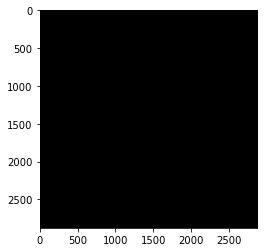

In [37]:
train_g, train_d, val_g ,val_d ,test_g ,test_d = prep_data(img_path, second_path)

In [42]:
train_g

90

In [41]:
train_d

85

In [40]:
val_g

64

In [39]:
val_d

60

In [38]:
test_g

60

In [43]:
test_d

70